In [1]:
import numpy as np
from scipy.integrate import ode
# Could potentially use any canned ode solver (or make your own)!

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3-D plots are a fantastic tool to visualize these particle trajectories.

# Useful for visual resolution.
%matplotlib notebook
%config InlineBackend.figure_format='retina'

$$ \dot{\rho}=\frac{X\dot{X}+Y\dot{Y}+Z\dot{Z}}{\sqrt{X^2+Y^2+Z^2}} $$\
$$ \dot{\theta}=\frac{\dot{X}Y-X\dot{Y}}{X^2+Y^2} $$\
$$ \dot{\phi} = \frac{Z(X\dot{X}+Y\dot{Y})-(X^2+Y^2)\dot{Z}}{(X^2+Y^2+Z^2)\sqrt{X^2+Y^2}} $$

In [2]:
"""Cartesian velocity to Spherical velocity!"""
def c_to_s_vel(pos,vel): # both in cartesian
    s_vel = []
    for i, c_vel in enumerate(vel):
        xd,yd,zd = c_vel[0],c_vel[1],c_vel[2]
        x,y,z = pos[i][0],pos[i][1],pos[i][2]
        rd = (x*xd+y*yd+z*zd)/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        td = (xd*y-x*yd)/(pow(x,2)+pow(y,2))
        pd = (z*(x*xd+y*yd)-(pow(x,2)+pow(y,2))*zd)/((pow(x,2)+pow(y,2)+pow(z,2))*np.sqrt(pow(x,2)+pow(y,2)))
        s_vel.append([rd,td,pd])
    return s_vel

$$ \dot{X}=\cos{\phi}\cos{\theta}\dot{\rho}+\rho\cos{\phi}\sin{\theta}\dot{\theta}+\rho\sin{\phi}\cos{\theta}\dot{\phi} $$\
$$ \dot{Y}=\cos{\phi}\sin{\theta}\dot{\rho}-\rho\cos{\phi}\cos{\theta}\dot{\theta}+\rho\sin{\phi}\sin{\theta}\dot{\phi} $$\
$$ \dot{Z}=\sin{\phi}\dot{\rho}-\rho\cos{\phi}\dot{\phi}$$

Interestingly, we find that python has issues with this trigonometric implementation. This is most likely due to a unit conflict or misunderstanding!

In [3]:
# """Spherical velocity to Cartesian velocity!"""
# def s_to_c_vel(pos,vel): # both in spherical
#     c_vel = []
#     for i, s_vel in enumerate(vel):
#         rd,td,pd = s_vel[0],s_vel[1],s_vel[2]
#         r,t,p = pos[i][0],pos[i][1],pos[i][2]
#         xd = np.cos(p)*np.cos(t)*rd+r*np.cos(p)*np.sin(t)*td+p*np.sin(p)*np.cos(t)*pd
#         yd = np.cos(p)*np.sin(t)*rd-r*np.cos(p)*np.cos(t)*td+r*np.sin(p)*np.sin(t)*pd
#         zd = np.sin(p)*rd-r*np.cos(p)*pd
#         c_vel.append([xd,yd,zd])
#     return c_vel

In [4]:
"""TEST DUPLICATE"""
def s_to_c_vel(pos,vel): # pos cart, vel spher
    c_vel = []
    for i, s_vel in enumerate(vel):
        rd,td,pd = s_vel[0],s_vel[1],s_vel[2]
        x,y,z = pos[i][0],pos[i][1],pos[i][2]
        xd = (x/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2)))*rd+y*td+((z*x)/np.sqrt(pow(x,2)+pow(y,2)))*pd
        yd = (y/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2)))*rd-x*td+((z*y)/np.sqrt(pow(x,2)+pow(y,2)))*pd
        zd = (z/np.sqrt(pow(x,2)+pow(y,2)+pow(z,2)))*rd-(np.sqrt(pow(x,2)+pow(y,2))*pd)
        c_vel.append([xd,yd,zd])
    return c_vel

In [5]:
def cart_to_sph(arr):
    sph_list = []
    for coord in arr:
        x,y,z = coord[0],coord[1],coord[2]
        r  = np.sqrt(pow(x,2)+pow(y,2)+pow(z,2))
        th = np.arccos(z/r)
        ph = np.arctan(y/x)
        sph_list.append([r,th,ph])
    return sph_list

In [6]:
def sph_to_cart(arr):
    cart_list = []
    for coord in arr:
        r,t,p = coord[0],coord[1],coord[2]
        x = r*np.sin(t)*np.cos(p)
        y = r*np.sin(t)*np.sin(p)
        z = r*np.cos(t)
        cart_list.append([x,y,z])
    return cart_list

In [7]:
def magDip(r, theta):
    B = np.zeros((2,1))

    fac   = B0 * (RE / r)**3
#     Br    = (2*m*np.cos(theta))/r**3
#     Bth   = (m*np.sin(theta))  /r**3 
    B[0]  = -2 * fac * np.cos(theta + alpha) # radial contribution
    B[1]  = -fac * np.sin(theta + alpha)     # polar angle cont.
    return B

In [8]:
def param(q,m,r,theta,i): # i=0=r, i=1=theta
    p = q/m*magDip(r,theta)[i]
    return p

In [9]:
"""Define the lorentz force equation for use in ODE solver.
   R represents our state vector (with associated cartesian positions
   and velocities), returns dR/dt."""
def lorentz(t,R,q,m):
    r, theta, phi    = R[0], R[1], R[2]
    vr, vtheta, vphi = R[3], R[4], R[5]

    return np.array([vr,vtheta,vphi, 
                     param(q,m,r,theta,1)*vr,
                     -vtheta*param(q,m,r,theta,0),
                     vphi*param(q,m,r,theta,0)-vphi*param(q,m,r,theta,1)]) #  cross product of (v spher. x B spher.).

In [21]:
N = 500

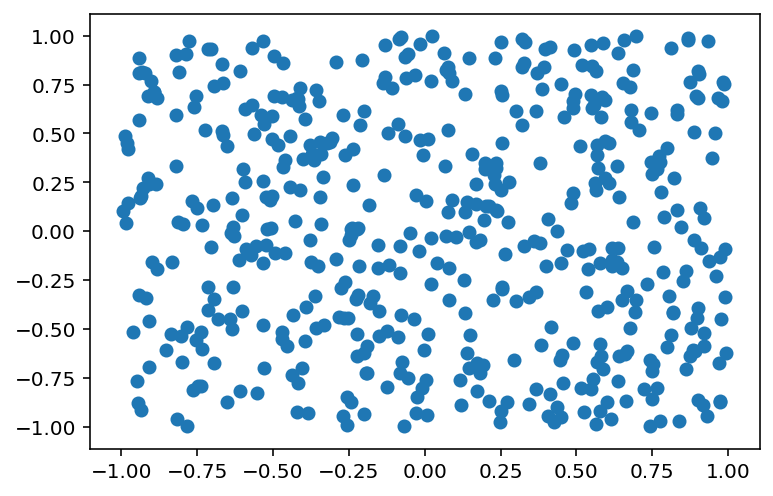

In [24]:
%matplotlib inline
x0 = np.array([2, 0, 0]) # r, theta, phi

randy = (np.random.random(N)*2)-1
randz = (np.random.random(N)*2)-1

xC = np.array([2,randy,randz])
fig = plt.figure()
plt.scatter(xC[1],xC[2])

In [13]:
x0 = []
for i,item in enumerate(randy):
#     x0.append([2, randy[i], randz[i]])
    x0.append([2, 0, 0])
    
before = x0
x0 = sph_to_cart(cart_to_sph(x0))
print(x0)

[[2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.2246467991473532e-16], [2.0, 0.0, 1.22464679914735

# Now the position conversion works for sure, but velocity is trickier!

<IPython.core.display.Javascript object>


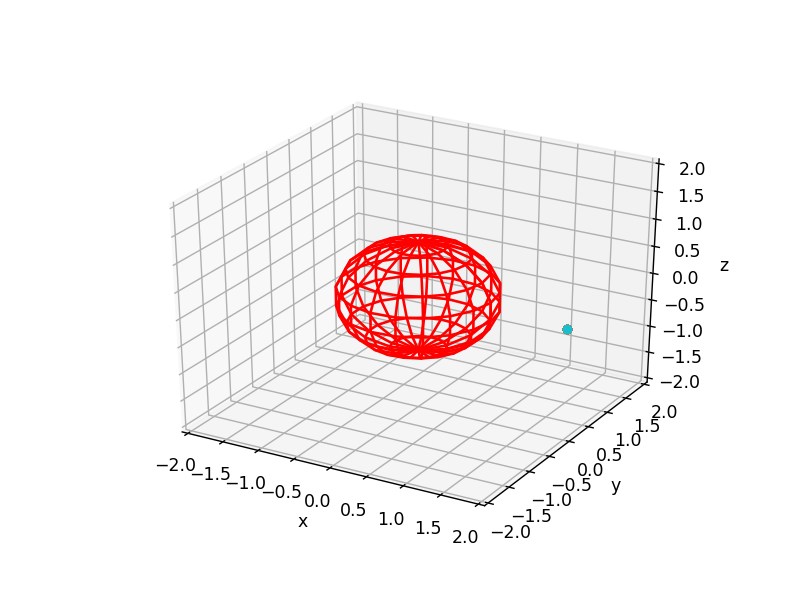

In [14]:
%matplotlib notebook
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r")

for i,each in enumerate(x0):
    ax.scatter(x0[i][0],x0[i][1],x0[i][2],'b')
    ax.scatter(before[i][0],before[i][1],before[i][2],'r')
plt.xlabel('x')
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_zlim(-2,2)
plt.ylabel('y')
ax.set_zlabel('z');

[[-0.09773978 -0.09283687 -0.07334491 -0.08283877 -0.06306293 -0.08152179
  -0.07707908 -0.067819   -0.09230816 -0.06121429 -0.09465965 -0.09745992
  -0.09941552 -0.05801331 -0.0905419  -0.0778524  -0.08759274 -0.09048269
  -0.09390595 -0.09314755 -0.08459603 -0.04942397 -0.07493828 -0.06350936
  -0.0791219  -0.07620789 -0.05659836 -0.09039516 -0.06607837 -0.07191568
  -0.06639133 -0.09988747 -0.06265556 -0.09924887 -0.07187188 -0.08218312
  -0.04719428 -0.09559956 -0.08285878 -0.06866888 -0.08152807 -0.09188404
  -0.06593626 -0.09181756 -0.10467126 -0.05398944 -0.06668104 -0.10252485
  -0.03892345 -0.09267369 -0.1232558  -0.08198944 -0.09178951 -0.05864888
  -0.08633496 -0.08918714 -0.06939052 -0.09074739 -0.05917796 -0.08766288
  -0.10080552 -0.08150808 -0.10789626 -0.06940085 -0.07863682 -0.0658808
  -0.11350201 -0.07101691 -0.03034333 -0.07033451 -0.0897667  -0.08098833
  -0.11919676 -0.0576779  -0.05359927 -0.05735698 -0.08974979 -0.08966925
  -0.0627432  -0.05719372 -0.04505196 -

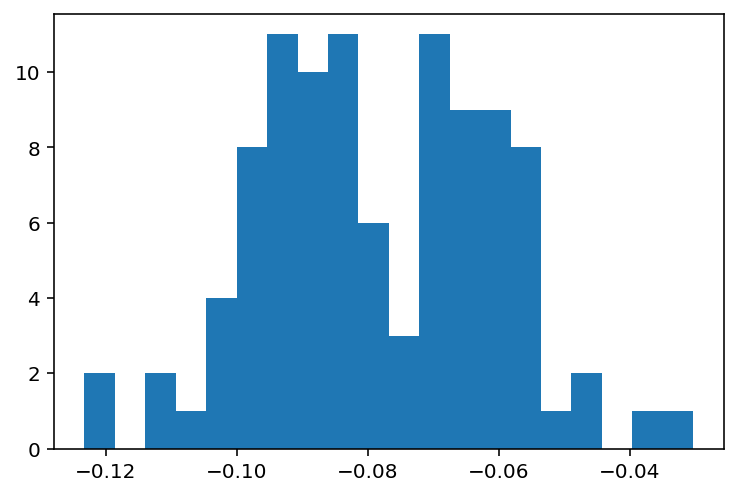

In [15]:
%matplotlib inline

# the center location comes from typical solar wind speed ~500 km/s.
# we know the Earth's radius is 6371 km: if we scale this to 1 unit of distance,
# we find that typical solar wind speeds account for 0.0785 km scales.
# solar wind varies by +- 250 km/s. Same calculation yields an approximate width or scale of 0.04.
randvx = np.random.normal(loc=-0.078480615288,scale=0.039240307644/2,size=N)

vC = np.array([randvx])
fig = plt.figure()
plt.hist(vC[0],bins=20);

print(vC)

In [15]:
# Let's initialize scipy's integration technique!
solver = ode(lorentz).set_integrator('vode') # Implements an explicit runge-kutta order (4).
# solver = ode(lorentz).set_integrator('dopri5') # Implements an explicit runge-kutta order (4).

In [16]:
t0 = 0
x0 = []
for i,item in enumerate(randy):
    x0.append([2, randy[i], randz[i]])
#     x0.append([2, 0.1, 0.1])

print('cartesian pos: ', x0)
v0 = []
for item in vC[0]:
    v0.append([item, 0, 0])
print('cartesian vel: ', v0)
    
    
    
v0 = c_to_s_vel(x0,v0) # both inputs need to be cartesian!
print('spher vel: ', v0)
x0 = cart_to_sph(x0)   # now we can convert positions to spherical.
print('spher pos: ', x0)

print('\ns->c vel: ', s_to_c_vel(sph_to_cart(x0),v0))
print('s->c pos: ', sph_to_cart(x0))
# print(sph_to_cart(x0))
# print(v0)
# print(s_to_c_vel(x0,v0)) # both should be spherical

cartesian pos:  [[2, -0.31200336585759003, -0.7333367970416553], [2, -0.80871588563925, 0.5281692888644587], [2, 0.8380173855277586, 0.5986735232191209]]
cartesian vel:  [[-0.06527308318572579, 0, 0], [-0.07178467617686188, 0, 0], [-0.09777374696126087, 0, 0]]
spher vel:  [[-0.060636372472281264, 0.004970393311984471, 0.010203624163583317], [-0.06464082339769202, 0.012473816337244278, -0.0071254283309126415], [-0.08692559700682617, -0.017424785287737027, -0.010667907349018613]]
spher pos:  [[2.1529349637649946, 1.918374599448848, -0.15475433362366225], [2.221032233306141, 1.3306924520908239, -0.3842575696862071], [2.2495962139571573, 1.3014256294541966, 0.39678503167272217]]

s->c vel:  [[-0.06527308318572579, 5.204170427930421e-18, -3.469446951953614e-18], [-0.07178467617686189, -8.456776945386935e-18, 3.469446951953614e-18], [-0.09777374696126087, -3.469446951953614e-18, 0.0]]
s->c pos:  [[2.0, -0.3120033658575901, -0.7333367970416552], [2.0000000000000004, -0.8087158856392501, 0.528

### These conversions now agree to a very high degree of accuracy. We are free to convert between spherical and cartesian with position as well as velocity arrays!

In [17]:
# B0 = 3.12e-5
# RE = 6.370
B0 = 1
RE = 1
alpha = np.radians(0)

### While the conversion functions work just fine, it seems that scipy ode integration causes even the initial positions to skew a noticable amount?

<IPython.core.display.Javascript object>


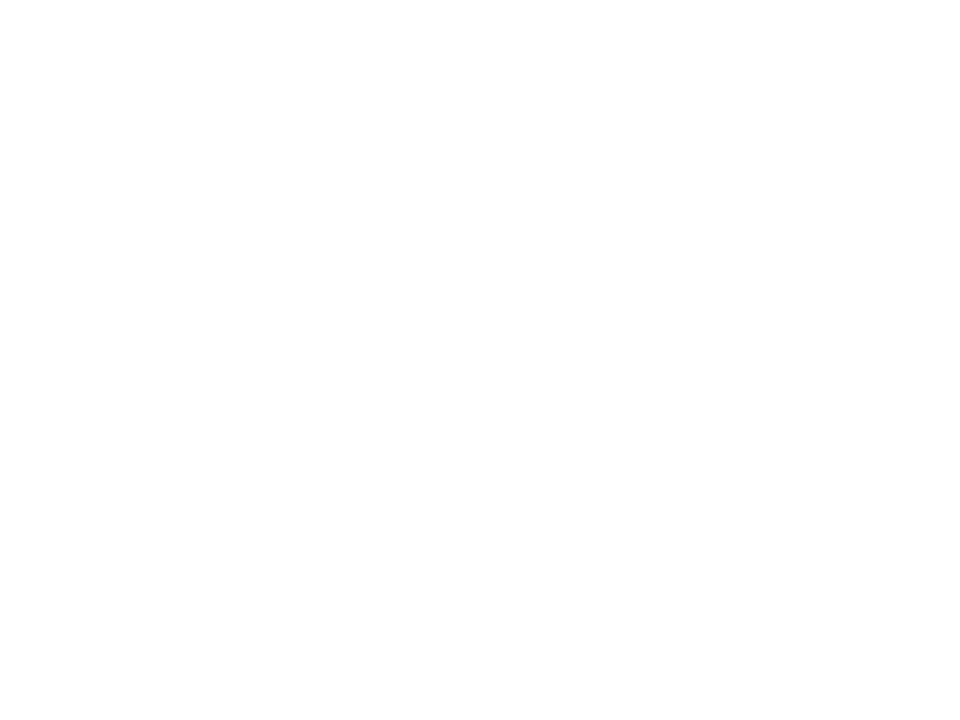

-3.630059394001909e-05
-0.00019927682105293698
0.00039161431496391886


In [18]:
%matplotlib notebook
%matplotlib notebook

posList = []
for index, particle in enumerate(x0):
    initial_conditions = np.concatenate((x0[index], v0[index]))
#     print(sph_to_cart([x0[index]]))
    solver.set_initial_value(initial_conditions, t0).set_f_params(1, 1) # set q, m, B strength.

    positions = []
    tf = 1000
    dt = 0.1

    # Iterate through scipy's ode solver --> tf.
    while solver.successful() and solver.t < tf:
        
        solver.integrate(solver.t+dt)
        positions.append(solver.y[:6]) # keep only pos (position and velocity?)!

    positions = np.array(positions)
    posList.append(positions)
    
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

for positions in posList:
#     print(np.min(positions[:,0]))
    cart = np.array(sph_to_cart(positions[:,:3]))
    cartvel = np.array(s_to_c_vel(cart, positions[:,3:6]))
    print(cartvel.T[1][0])

    ax.scatter3D(cart.T[0], cart.T[1], cart.T[2],alpha=0.75,s=0.2) # solution x, y, z
    ax.scatter3D(cart.T[0][0],cart.T[1][0],cart.T[2][0],color='red')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="hotpink")

### Woah, this is almost reminiscent of a heat map for the trajectory of a given particle!

I suppose wherever it spends the most time, the more points you are likely to see clumped together. Thus, we see a slow-moving initial trajectory, which quickly turns into an orbit around the Earth with certain lattitudes more typical than others.

# Although, a couple of things:

We need to worry about how we interpret the scaling of things. If we choose to set the radius of the Earth as 1, then the strength of the magnetic field must also be scaled accordingly? Seems like the velocities were chosen just fine?

Furthermore, conversions of coordinate systems must be ensured to be accurate.\
As of now, initial positions seem to be working.

We must verify initial velocities, and then also confirm the legitimacy of scipy's ODE int!

## Parameters are very troublesome. Units and consistency will be important. 
#### Are we assuming electrons? What are the charges q, masses m, energies? How will creeping numerical error be taken care of? If we make the values of q and m too small, initial conditions drift away.

In [19]:
# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 40, dt)

In [20]:
T=2.*np.pi
h=T/50.     # change this and explore!!!!!!!!!!!!!!!!!!!!!!
ttot=3.*T
#
figwidth=5
figheight=5

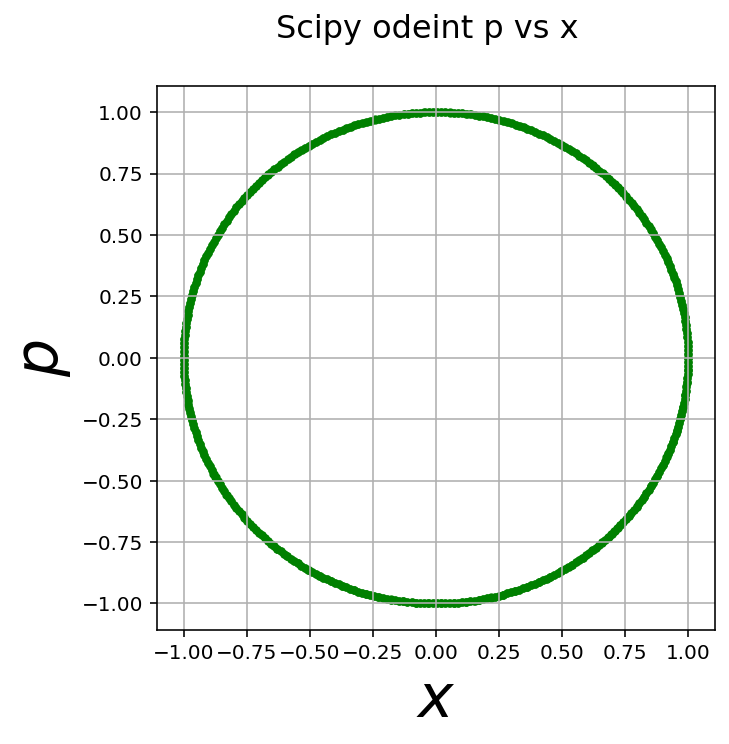

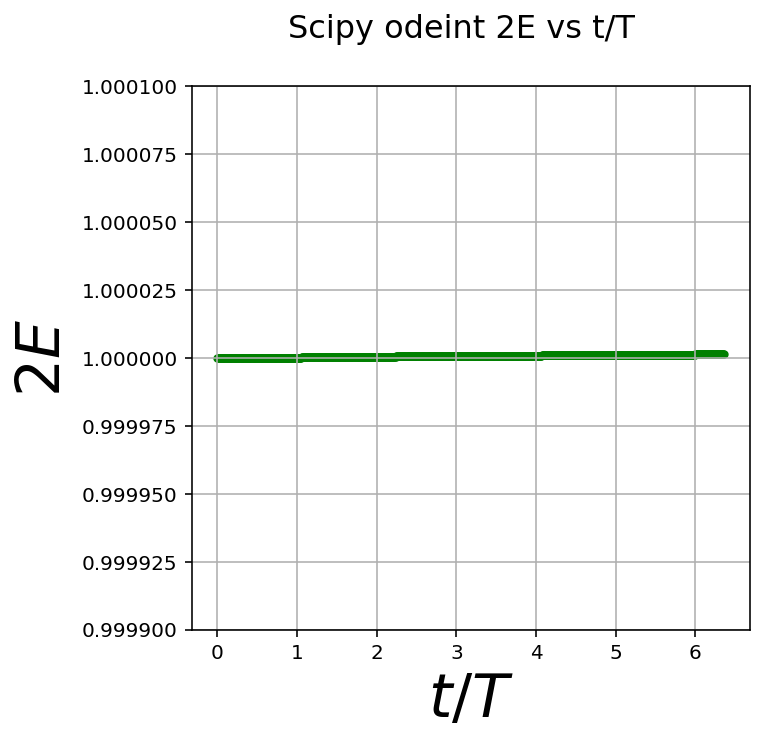

In [21]:
import scipy.integrate as integrate
# This is the pair of derivative functions that define the SHO
def SHO(Y, t):
    # let Y[0] be x, Y[1] be p
    return [Y[1], -Y[0]]

%matplotlib inline
Y = integrate.odeint(SHO, [1, 0], t)
fig5=plt.figure(5,[figwidth,figheight])
ax=fig5.gca()
ax.grid(True)
fig5.suptitle('Scipy odeint p vs x', fontsize=16)
# **** might be worth mentioning here there are two pretty much equivalent ways to make this call
#plt.scatter(Y[:,0], Y[:,1], 10, 'g')
plt.scatter(*Y.T, 10, 'g')
# ****
ax.set_xlabel('$x$', size=30)                 #labels
ax.set_ylabel('$p$',size=30)
# we'll also talk about this line in class:*********************************
E2scipy=(pow(Y[:,1],2)+pow(Y[:,0],2))
fig6=plt.figure(6,[figwidth,figheight])
ax=fig6.gca()
ax.grid(True)
fig6.suptitle('Scipy odeint 2E vs t/T', fontsize=16)
plt.scatter(t/T, E2scipy, 10, 'g')
ax.set_ylim([.9999, 1.0001])
ax.set_xlabel('$t/T$', size=30)                 #labels
ax.set_ylabel('$2E$',size=30)
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

Try originating from same position, but different velocities!

In [22]:
print(initial_conditions.dtype)
print(t.dtype)

float64
float64


-3.469446951953614e-18


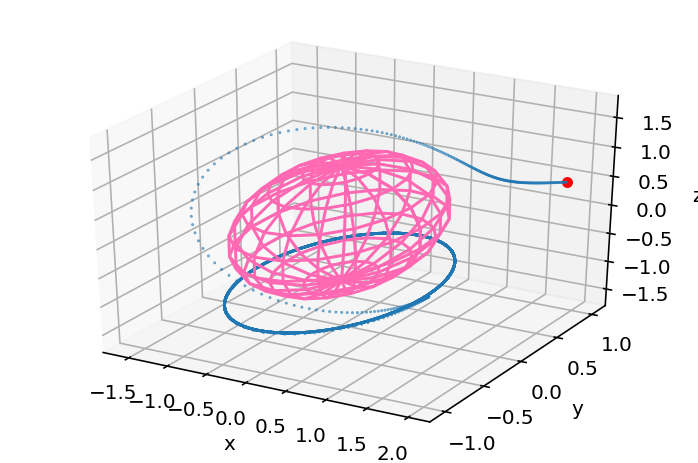

In [23]:
def lorentz(t,R,q,m):
    r, theta, phi    = R[0], R[1], R[2]
    vr, vtheta, vphi = R[3], R[4], R[5]

    return np.array([vr,vtheta,vphi, 
                     (q/m)*((-B0 * (RE / r)**3)*np.sin(theta + alpha))*vr,
                     -vtheta*(q/m)*(-2 * (B0 * (RE / r)**3) * np.cos(theta + alpha)),
                     vphi*(q/m)*(-2 * (B0 * (RE / r)**3) * np.cos(theta + alpha))-
                     vphi*(q/m)*(-(B0 * (RE / r)**3) * np.sin(theta + alpha))]) #  cross product of (v spher. x B spher.).

dt = 0.1
t = np.arange(0.0, 500, dt)

q=1;m=1
positions = integrate.odeint(func=lorentz,y0=initial_conditions,t=t,args=(q,m),tfirst=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

cart = np.array(sph_to_cart(positions[:,:3]))
cartvel = np.array(s_to_c_vel(cart, positions[:,3:6]))
print(cartvel.T[1][0])

ax.scatter3D(cart.T[0], cart.T[1], cart.T[2],alpha=0.75,s=0.2) # solution x, y, z
ax.scatter3D(cart.T[0][0],cart.T[1][0],cart.T[2][0],color='red')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="hotpink")

In [24]:
solver = ode(lorentz).set_integrator('vode') # Implements an explicit runge-kutta order (4).

<IPython.core.display.Javascript object>


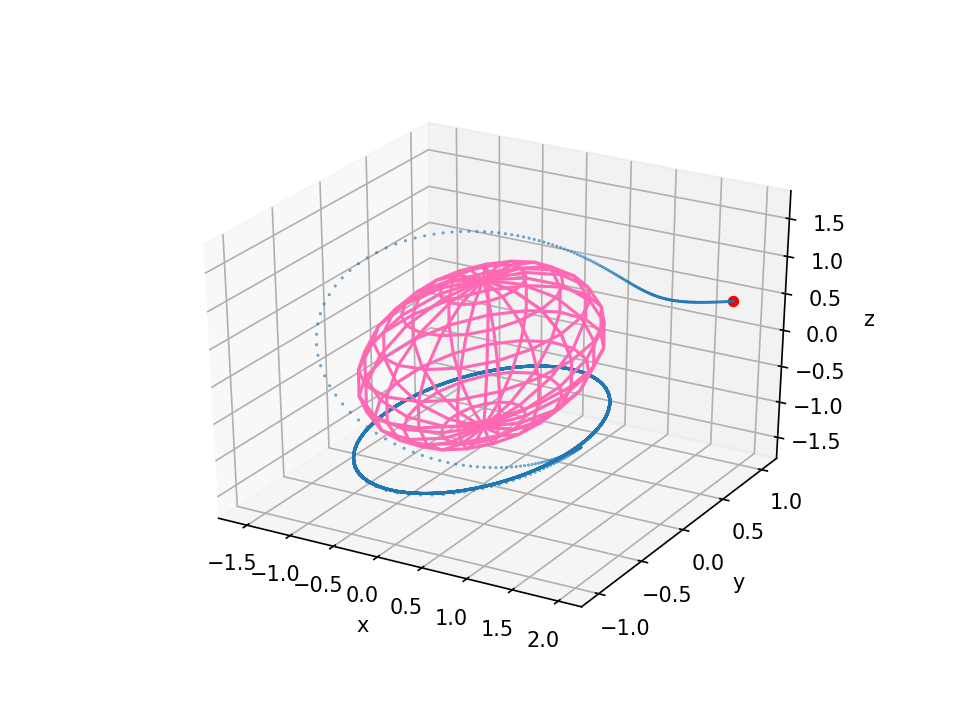

0.00039161431496391886


In [25]:
%matplotlib notebook
%matplotlib notebook

solver.set_initial_value(initial_conditions, t0).set_f_params(1, 1) # set q, m, B strength.

positions = []
tf = 1000
dt = 0.1

# Iterate through scipy's ode solver --> tf.
while solver.successful() and solver.t < tf:

    solver.integrate(solver.t+dt)
    positions.append(solver.y[:6]) # keep only pos (position and velocity?)!

positions = np.array(positions)
    
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # initialize a 3-D plot.

cart = np.array(sph_to_cart(positions[:,:3]))
cartvel = np.array(s_to_c_vel(cart, positions[:,3:6]))
print(cartvel.T[1][0])

ax.scatter3D(cart.T[0], cart.T[1], cart.T[2],alpha=0.75,s=0.2) # solution x, y, z
ax.scatter3D(cart.T[0][0],cart.T[1][0],cart.T[2][0],color='red')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="hotpink")

OK, I've tested both ways with scipy odeint (using loops and just a single call with a time array). It seems very similar in computational time?

Also, the same results are yielded: thus, whatever horrible things are happening are due to my state function or implementation :-(